<a href="https://www.kaggle.com/code/minhthonglai/ielts-llm-tuner?scriptVersionId=244293935" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# LLM Fine-tuning for Essay Scoring

- Download lastest output: [ielts-LLM-tuner's output](https://www.kaggle.com/api/v1/kernels/output/download/minhthonglai/ielts-llm-tuner)

## Global Setting Variables

In [1]:
MODEL_ID = "EleutherAI/gpt-j-6B" # Using GPT-J
MODEL_PATH = 'models/'
LOAD_MODEL_PATH = 'models/pretrained_gpt2'
COMPRESSED_MODEL_PATH = 'compressed_models/'
DATA_PATH = 'data/'
RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.
LOAD_MODEL = True
TRAIN_MODEL = True
SAVE_MODEL = True
TARGET_MODULES = ["q_proj", "v_proj"],  # GPT-J attention layers

## System configurations 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when create a version using "Save & Run All" 
# Can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

/kaggle/input/ielts-writing-tasks/generate_synthetic_data.txt
/kaggle/input/ielts-writing-tasks/synthetic_data_.json
/kaggle/input/ielts-writing-tasks/synthetic_data.json
Python Version: `3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]`
Base Python location: `/usr`
Current Environment location: `usr`



In [3]:
import torch
import time  # for CPU timing

# Check if GPU is available and being used
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")

# This code will work in both CPU and GPU environments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Test with a simple operation - modified to work on both CPU and GPU
x = torch.rand(10000, 10000, device=device)
y = torch.rand(10000, 10000, device=device)

if device.type == "cuda":
    # GPU timing approach
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    z = x @ y  # Matrix multiplication
    end.record()
    torch.cuda.synchronize()
    print(f"Operation time: {start.elapsed_time(end)} ms")
else:
    # CPU timing approach
    start_time = time.time()
    z = x @ y  # Matrix multiplication
    end_time = time.time()
    print(f"Operation time: {(end_time - start_time) * 1000} ms")

CUDA available: False
Using device: cpu
Operation time: 15540.437936782837 ms


## Install required libraries

In [4]:
# %pip install transformers peft datasets accelerate bitsandbytes trl
# %pip install sentencepiece

## Import Libraries and Set Configuration

In [5]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, EarlyStoppingCallback, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from datasets import Dataset, load_dataset

import os
import re
import time
import json
import shutil
import requests
from IPython.display import FileLinks, FileLink
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

np.random.seed(RANDOM_SEED)

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available. Setting up GPU environment...")
    # Set maximum GPU memory usage to avoid OOM errors
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    torch.cuda.empty_cache()
else:
    print("No GPU detected. Running in CPU-only mode.")
    # Ensure CUDA is disabled
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Enable memory efficient attention - works for both CPU and GPU
os.environ["TRANSFORMERS_OFFLINE"] = "1"  # Work offline if model is downloaded

2025-06-08 00:49:46.529090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749343786.797693      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749343786.881080      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


No GPU detected. Running in CPU-only mode.


## Prepare the IELTS Dataset

In [6]:
# Save `dict()` into `.json` files
def saveJSON(data, json_path="data.json"):
    os.makedirs(os.path.dirname(json_path), exist_ok=True) # Create folder if does not exist 
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

# Load `.json` files
def loadJSON(json_path='data.json'):
    with open(json_path) as f:
        data = json.load(f)
    return data

### Sample code to create a dataset for IELTS assessment


Need to prepare the dataset with this structure:

```
Data format structure:

data = {
  "prompt": [
    """[topic essay text]"""
    ],

  "essay": [
    """[student essay text]"""
    ],

  "evaluation": [
    """Task Achievement: [band score] - [detailed feedback]

Coherence and Cohesion: [band score] - [detailed feedback]

Lexical Resource: [band score] - [detailed feedback]

Grammatical Range and Accuracy: [band score] - [detailed feedback]

Overall Band Score: [band score]"""
    ],

  "band": [
    "[band score]"
    ]
}
```

In [7]:
# def download_file(url, save_path, file_name=None, extract=False, force_download=False):
#     """Download a file and optionally extract if it's compressed."""
#     print(f"URL: {url}")
    
#     if not file_name:
#         file_name = os.path.basename(url)

#     # If not forcing download and the file already exists, skip downloading.
#     if not force_download and os.path.exists(os.path.join(save_path, file_name)):
#         print(f"File `{os.path.join(save_path, file_name)}` already exists.")
#         return

#     os.makedirs(save_path, exist_ok=True)
    
#     # Adjust file name if extraction is expected (e.g., assume download is a zip file)
#     file_name += '.zip' if extract else ''
#     file_path = os.path.join(save_path, file_name)
    
#     # Send GET request in streaming mode
#     response = requests.get(url, stream=True)
#     if response.status_code != 200:
#         print(f"| Failed: [{response.reason}]")
#         return response

#     # Get the total size from the response header (if available)
#     total_size = int(response.headers.get('Content-Length', 0))
#     chunk_size = 1024  # 1KB chunks

#     # Open the output file and use tqdm to show the progress bar.
#     with open(file_path, 'wb') as f, tqdm(
#         total=total_size, unit='B', unit_scale=True, desc=f"Downloading `{file_name}`"
#     ) as pbar:
#         for chunk in response.iter_content(chunk_size=chunk_size):
#             if chunk:  # filter out keep-alive new chunks
#                 f.write(chunk)
#                 pbar.update(len(chunk))
    
#     # Extract the archive if requested
#     if extract:
#         try:
#             shutil.unpack_archive(file_path, extract_dir=save_path)
#             print(f"Extracted archive... ", end='')
#             # Remove the archive file after extraction
#             os.remove(file_path)
#         except shutil.ReadError:
#             print(f"| Note: {file_path} is not an archive or could not be extracted ", end='')
    
#     print(f"| Succeeded")
#     return response
    
# def download_dataset_from_kaggle(file_name=None, save_path=DATA_PATH, extract=False, force_download=False,
#                                  dataset_url="datasets/download/minhthonglai/ielts-writing-tasks"):
#     # Download the dataset from Kaggle
#     BASE_URL = "https://www.kaggle.com/api/v1"

    
#     # Factor char list
#     download_file(
#         f'{BASE_URL}/{dataset_url}/{file_name}',
#         save_path,
#         file_name,
#         extract,
#         force_download
#     )

In [8]:
# KAGGLE_DATA_PATH = "/kaggle/input/ielts-writing-tasks/synthetic_data.json"
# SYNTHETIC_DATA_PATH = os.path.join(DATA_PATH, f"synthetic_data.json")

# if os.path.exists(KAGGLE_DATA_PATH):
#     data = loadJSON(KAGGLE_DATA_PATH)
#     saveJSON(data, SYNTHETIC_DATA_PATH)
# else:
#     download_dataset_from_kaggle('synthetic_data.json')
#     data = loadJSON(SYNTHETIC_DATA_PATH)

In [9]:
# # Load comprehensive data for IELTS assessment across different levels

# SYNTHETIC_DATA_PATH = os.path.join(DATA_PATH, f"synthetic_data.json")
# data = loadJSON(SYNTHETIC_DATA_PATH)

# # Create dataset from your dictionary
# dataset = Dataset.from_dict(data)
# print(f"Dataset created with {len(dataset)} entries")

# # Use train_test_split for cleaner splitting
# dataset = dataset.train_test_split(test_size=0.2, seed=RANDOM_SEED)

In [10]:
from datasets import load_dataset

dataset = load_dataset("chillies/IELTS-writing-task-2-evaluation")
dataset = dataset.map(lambda x: {**x, 'band': x['band'].strip()}) # Strip the `band` feature
dataset

train.csv:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9833 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/9833 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 9833
    })
    test: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 491
    })
})

### Band Score Distribution in the dataset

In [11]:
def plot_band_score_distribution(dataset, title="IELTS Band Score Distribution", plot_splits_separately=False):
    """
    Plot distribution of IELTS band scores from DatasetDict.
    
    Parameters:
    dataset (DatasetDict): A Hugging Face DatasetDict containing IELTS assessments
    plot_splits_separately (bool): If True, plot train and test separately
    """
    
    def extract_scores_from_split(split_data, split_name):
        """Extract band scores from a dataset split"""
        scores = []
        for example in split_data:
            try:
                score = float(example['band'])
                if 1.0 <= score <= 9.0:  # Valid IELTS range
                    scores.append(score)
            except (ValueError, AttributeError):
                continue
        
        print(f"{split_name} split: {len(scores)} valid scores out of {len(split_data)} examples")
        return np.array(scores)
    
    # Extract scores from all splits
    all_scores = []
    split_scores = {}
    
    for split_name, split_data in dataset.items():
        scores = extract_scores_from_split(split_data, split_name)
        split_scores[split_name] = scores
        all_scores.extend(scores)
    
    all_scores = np.array(all_scores)
    
    if len(all_scores) == 0:
        print("No valid band scores found.")
        return
    
    # Auto-determine the range based on actual data
    min_score = all_scores.min()
    max_score = all_scores.max()
    
    # Round to nearest 0.5 and extend slightly for better visualization
    min_range = np.floor(min_score * 2) / 2  # Round down to nearest 0.5
    max_range = np.ceil(max_score * 2) / 2   # Round up to nearest 0.5
    
    print(f"Score range in dataset: {min_score:.1f} - {max_score:.1f}")
    print(f"Plot range: {min_range:.1f} - {max_range:.1f}")
    
    # Plotting
    if plot_splits_separately and len(split_scores) > 1:
        # Plot train and test separately
        fig, axes = plt.subplots(1, len(split_scores), figsize=(6*len(split_scores), 5))
        if len(split_scores) == 2:
            axes = [axes[0], axes[1]] if hasattr(axes, '__len__') else [axes]
        
        for idx, (split_name, scores) in enumerate(split_scores.items()):
            ax = axes[idx] if len(split_scores) > 1 else axes
            plot_single_distribution(scores, ax, f"{split_name.title()} Split ({len(scores)} essays)", 
                                   min_range, max_range)
    
    else:
        # Plot combined distribution
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_single_distribution(all_scores, ax, f"{title} (Combined: {len(all_scores)} essays)",
                               min_range, max_range)
    
    plt.tight_layout()
    plt.show()
    
    # Print distribution statistics
    print("\n" + "="*50)
    print("BAND SCORE STATISTICS")
    print("="*50)
    
    for split_name, scores in split_scores.items():
        if len(scores) > 0:
            print(f"\n{split_name.upper()} SPLIT:")
            print_score_stats(scores)
    
    if len(split_scores) > 1:
        print(f"\nCOMBINED:")
        print_score_stats(all_scores)

def plot_single_distribution(band_scores, ax, title, min_range, max_range):
    """Plot distribution for a single set of scores with auto-adjusted range"""
    if len(band_scores) == 0:
        ax.text(0.5, 0.5, 'No valid scores', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return
    
    # Create bins based on the actual data range
    bins = np.arange(min_range, max_range + 0.5, 0.5)
    counts, edges = np.histogram(band_scores, bins=bins)
    
    # Create bar plot
    ax.bar(edges[:-1], counts, width=0.4, color="skyblue", edgecolor="navy", alpha=0.7)
    
    # Add KDE if enough data points
    if len(band_scores) > 10:
        kde = gaussian_kde(band_scores)
        x_kde = np.linspace(band_scores.min(), band_scores.max(), 100)
        # Scale KDE to match histogram scale
        kde_scaled = kde(x_kde) * len(band_scores) * 0.5
        ax.plot(x_kde, kde_scaled, color="red", linewidth=2, alpha=0.6, label='Density curve')
    
    # Add mean line
    mean_score = band_scores.mean()
    ax.axvline(mean_score, color="red", linestyle="--", linewidth=2)
    ax.text(mean_score+0.1, ax.get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', 
            fontsize=10, color='red', fontweight='bold')
    
    # Styling with auto-adjusted x-axis
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Band Score", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_xticks(bins[:-1])  # Use the auto-generated bins
    ax.set_xlim(min_range - 0.25, max_range + 0.25)  # Add small padding
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def print_score_stats(scores):
    """Print detailed statistics for band scores"""
    if len(scores) == 0:
        print("  No valid scores")
        return
    
    unique, counts = np.unique(scores, return_counts=True)
    
    print(f"  Total essays: {len(scores)}")
    print(f"  Mean: {scores.mean():.2f}")
    print(f"  Median: {np.median(scores):.2f}")
    print(f"  Range: {scores.min():.1f} - {scores.max():.1f}")
    print(f"  Std Dev: {scores.std():.2f}")
    print(f"  Distribution:")
    for score, count in zip(unique, counts):
        percentage = (count / len(scores)) * 100
        print(f"    Band {score}: {count} essays ({percentage:.1f}%)")


train split: 9259 valid scores out of 9833 examples
test split: 453 valid scores out of 491 examples
Score range in dataset: 4.0 - 9.0
Plot range: 4.0 - 9.0


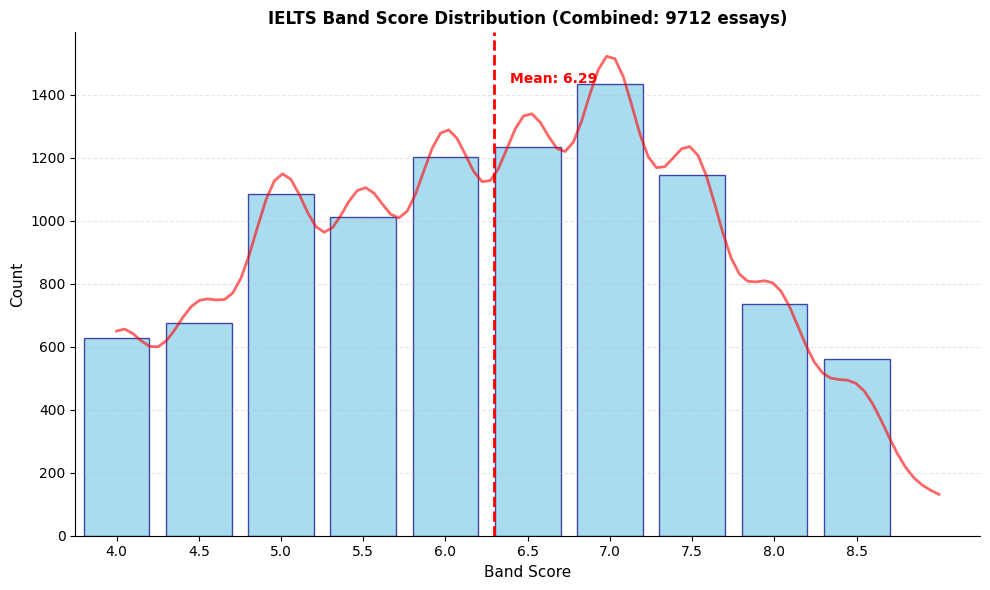


BAND SCORE STATISTICS

TRAIN SPLIT:
  Total essays: 9259
  Mean: 6.29
  Median: 6.50
  Range: 4.0 - 9.0
  Std Dev: 1.27
  Distribution:
    Band 4.0: 594 essays (6.4%)
    Band 4.5: 646 essays (7.0%)
    Band 5.0: 1049 essays (11.3%)
    Band 5.5: 955 essays (10.3%)
    Band 6.0: 1143 essays (12.3%)
    Band 6.5: 1168 essays (12.6%)
    Band 7.0: 1358 essays (14.7%)
    Band 7.5: 1105 essays (11.9%)
    Band 8.0: 700 essays (7.6%)
    Band 8.5: 433 essays (4.7%)
    Band 9.0: 108 essays (1.2%)

TEST SPLIT:
  Total essays: 453
  Mean: 6.26
  Median: 6.50
  Range: 4.0 - 9.0
  Std Dev: 1.22
  Distribution:
    Band 4.0: 33 essays (7.3%)
    Band 4.5: 30 essays (6.6%)
    Band 5.0: 35 essays (7.7%)
    Band 5.5: 58 essays (12.8%)
    Band 6.0: 58 essays (12.8%)
    Band 6.5: 67 essays (14.8%)
    Band 7.0: 76 essays (16.8%)
    Band 7.5: 41 essays (9.1%)
    Band 8.0: 35 essays (7.7%)
    Band 8.5: 16 essays (3.5%)
    Band 9.0: 4 essays (0.9%)

COMBINED:
  Total essays: 9712
  Mean: 6.29

In [12]:
plot_band_score_distribution(dataset)

### Split dataset

In [13]:
train_dataset = dataset['train'].take(2)
test_dataset = dataset['test'].take(2)

# train_dataset = dataset['train']
# test_dataset = dataset['test']

print(f"Training entries: {len(train_dataset)}")
print(f"Testing entries: {len(test_dataset)}")

Training entries: 2
Testing entries: 2


## Load model with Quantization for Memory Efficiency

In [14]:
# Define quantization configuration
if torch.cuda.is_available():
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
else:
    None

if LOAD_MODEL and os.path.exists(LOAD_MODEL_PATH):
    # Load the base model WITH appropriate quantization
    if torch.cuda.is_available():
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=quantization_config, # GPU: Use 4-bit quantization 
            torch_dtype=torch.float16,
            device_map="auto"
        )
    else:
        # CPU: Use memory-efficient loading
        cpu_model_id = "distilgpt2"  # Only 82M parameters vs 6B
        model = AutoModelForCausalLM.from_pretrained(
            cpu_model_id,
            low_cpu_mem_usage=True,
            device_map="auto"
        )
    
    print(f"Load tokenizer from {LOAD_MODEL_PATH}...")
    tokenizer = AutoTokenizer.from_pretrained(LOAD_MODEL_PATH)
    tokenizer.pad_token = tokenizer.eos_token  # Re-set padding token
else:    
    # Check if GPU is available
    if torch.cuda.is_available():
        print("GPU detected! Using 4-bit quantization...")
        # Load with quantization for GPU
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=quantization_config, # GPU: Use 4-bit quantization
            torch_dtype=torch.float16,
            device_map="auto"
        )
    else:
        print("No GPU detected! For development, using a smaller model instead...")
        # For CPU development, consider using a much smaller model
        # Most LLM are too large for most CPU environments
        cpu_model_id = "distilgpt2"  # Only 82M parameters vs 6B
        model = AutoModelForCausalLM.from_pretrained(
            cpu_model_id,
            low_cpu_mem_usage=True,
            device_map="auto"
        )
        print(f"⚠️ NOTE: Using {cpu_model_id} instead of {MODEL_ID} for CPU development!")
        print("⚠️ Remember to switch to GPU when ready for actual fine-tuning")
    
    # Get the tokenizer for whatever model we loaded
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID if torch.cuda.is_available() else cpu_model_id)
    tokenizer.pad_token = tokenizer.eos_token  # Set padding token

No GPU detected! For development, using a smaller model instead...


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

⚠️ NOTE: Using distilgpt2 instead of EleutherAI/gpt-j-6B for CPU development!
⚠️ Remember to switch to GPU when ready for actual fine-tuning


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Configure LoRA for Parameter-Efficient Fine-Tuning

In [15]:
if LOAD_MODEL and os.path.exists(LOAD_MODEL_PATH):
    print(f"Load LoRA adapters from {LOAD_MODEL_PATH}...")
    model = PeftModel.from_pretrained(model, LOAD_MODEL_PATH, is_trainable=TRAIN_MODEL)
else:
    target_modules = TARGET_MODULES if torch.cuda.is_available() else ["c_attn", "c_proj", "c_fc", "lm_head"]
    
    # For GPT-J style models:
    peft_config = LoraConfig(
        r=8,                     # Rank dimension
        lora_alpha=32,           # Alpha parameter for LoRA scaling
        lora_dropout=0.1,        # Dropout probability for LoRA layers
        bias="none",
        task_type="CAUSAL_LM",
        target_modules = target_modules
    )
    
    # Apply LoRA to model
    model = get_peft_model(model, peft_config)

# Print configuration
print(f"Current model: `{model.config.model_type}` from `{model.config._name_or_path}`")
print(f"Using target modules for `{model.config.model_type}` style architecture: {model.peft_config['default'].target_modules}")

# Print trainable parameters to verify setup
model.print_trainable_parameters()


# Check more detailed information
print("\nModel details:")
print(f"Architecture: {model.__class__.__name__}")
if hasattr(model, 'config'):
    print(f"Hidden size: {model.config.hidden_size}")
    print(f"Vocabulary size: {model.config.vocab_size}")
    print(f"Number of parameters: {(sum(p.numel() for p in model.parameters())/1000000):.2f}M")
    print(f"Model's maximum token length: {model.config.max_position_embeddings}")

Current model: `gpt2` from `distilgpt2`
Using target modules for `gpt2` style architecture: {'lm_head', 'c_fc', 'c_proj', 'c_attn'}
trainable params: 998,024 || all params: 82,910,600 || trainable%: 1.2037

Model details:
Architecture: PeftModelForCausalLM
Hidden size: 768
Vocabulary size: 50257
Number of parameters: 82.91M
Model's maximum token length: 1024


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1255: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


## Define Training Arguments

In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=1,   # Keep small due to memory constraints
    per_device_eval_batch_size=1,    # Add eval batch size
    gradient_accumulation_steps=4,   # Accumulate gradients to simulate larger batch
    save_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True if torch.cuda.is_available() else False, # Use mixed precision
    report_to="none",                # Disable wandb reporting
    optim="adamw_torch",
    max_grad_norm=0.3,               # Gradient clipping
    warmup_ratio=0.03,               # Warmup for learning rate

    # Early stopping related arguments
    eval_strategy="steps",      # Evaluate every N steps
    eval_steps=50,                   # Evaluate every 50 steps
    # save_strategy="steps",           # Save model every N steps
    metric_for_best_model="eval_loss", # Metric to monitor
    greater_is_better=False,         # Lower loss is better
    load_best_model_at_end=True,     # Load best model when training ends
)

## Set Up Trainer

In [17]:
# class IELTSDataCollator:
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer
        
#     def __call__(self, entries):
#         # Extract input and output
#         inputs = [entry["input"] for entry in entries]
#         outputs = [entry["output"] for entry in entries]
        
#         # Format the text (input followed by output)
#         texts = [f"<|user|>\n{inp}\n<|assistant|>\n{out}</s>" for inp, out in zip(inputs, outputs)]
        
#         # Tokenize
#         batch = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
#         # For causal language modeling, use the input_ids as labels too
#         batch["labels"] = batch["input_ids"].clone()
        
#         return batch

# # Create the custom data collator
# data_collator = IELTSDataCollator(tokenizer)


In [18]:
def preprocess_function(entries):
    # Format the text
    texts = []
    for i in range(len(entries['prompt'])):
        # Create input text from prompt and essay
        input_text = f"""You are an experienced IELTS examiner trained to assess Writing Task 2 essays. Evaluate this essay using the official IELTS band descriptors:

**TASK**: Assess the essay below according to these four criteria:

**Task Achievement (1-9)**: 
- How fully the task is addressed
- How clearly position is presented and developed
- How well ideas are extended and supported

**Coherence and Cohesion (1-9)**:
- Overall progression and organization
- Use of cohesive devices
- Logical sequencing of ideas

**Lexical Resource (1-9)**:
- Range and accuracy of vocabulary
- Appropriateness of word choice
- Spelling accuracy

**Grammatical Range and Accuracy (1-9)**:
- Range of sentence structures
- Accuracy of grammar and punctuation
- Error frequency and impact

**Topic**: {entries['prompt'][i]}

**Student Essay**: {entries['essay'][i]}

Provide detailed assessment for each criterion with specific examples from the text."""

        
        # Create the full conversation format
        conversation = f"<|user|>\n{input_text}\n<|assistant|>\n{entries['evaluation'][i]}</s>"
        texts.append(conversation)
    
    # Tokenize
    tokenized = tokenizer(texts, padding="max_length", truncation=True, max_length=512)
    
    # For language modeling
    tokenized["labels"] = tokenized["input_ids"].copy()
    
    return tokenized

# Process the dataset
processed_train_dataset = train_dataset.map(
    preprocess_function, 
    batched=True,
    remove_columns=train_dataset.column_names  # Remove the original columns
)

processed_test_dataset = test_dataset.map(
    preprocess_function, 
    batched=True,
    remove_columns=test_dataset.column_names  # Remove the original columns
)

# Define the Trainer with processed dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_dataset,
    eval_dataset=processed_test_dataset,      # Validation data (part of test set)
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop after 3 evaluations without improvement
)

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Start Fine-Tuning

In [19]:
if TRAIN_MODEL:
    # Start training
    trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [20]:
# # Data collator
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# # Define custom data formatting function
# def formatting_func(entries):
#     texts = []
#     for i in range(len(entries["input"])):
#         text = f"<|user|>\n{entries['input'][i]}\n<|assistant|>\n{entries['output'][i]}</s>"
#         texts.append(text)
#     return texts

# # Define the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
# )

# # Start training
# trainer.train()

## Save the Fine-Tuned Model

In [21]:
if SAVE_MODEL:
    CURRENT_MODEL_PATH = os.path.join(MODEL_PATH, f"pretrained_{model.config.model_type}")
    
    # Save the model (just the LoRA weights, not the full model)
    model.save_pretrained(CURRENT_MODEL_PATH)
    tokenizer.save_pretrained(CURRENT_MODEL_PATH)
    
    # Download the model to the local machine
    display(FileLinks(CURRENT_MODEL_PATH))

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


models/pretrained_gpt2/
  adapter_config.json
  special_tokens_map.json
  merges.txt
  README.md
  adapter_model.safetensors
  tokenizer_config.json
  vocab.json
  tokenizer.json

### Zip into a file
For downloading in case running on online platform like Kaggle

In [22]:
if SAVE_MODEL:
    CURRENT_COMPRESSED_MODEL_PATH = os.path.join(COMPRESSED_MODEL_PATH, f"pretrained_{model.config.model_type}")
    
    # Create the directory if it doesn't exist
    os.makedirs(COMPRESSED_MODEL_PATH, exist_ok=True)
    
    # Create zip file (method 1: using Python's shutil)
    shutil.make_archive(
        CURRENT_COMPRESSED_MODEL_PATH,
        'zip',
        os.path.dirname(CURRENT_MODEL_PATH),
        os.path.basename(CURRENT_MODEL_PATH),
    )
    
    # Alternative for Jupyter/Colab environments (method 2)
    # !zip -r {CURRENT_COMPRESSED_MODEL_PATH}.zip {CURRENT_MODEL_PATH}
    
    # Create download link in Jupyter/Colab
    display(FileLink(f"{CURRENT_COMPRESSED_MODEL_PATH}.zip"))

/kaggle/working/compressed_models/pretrained_gpt2.zip

## Test the Fine-Tuned Model

In [23]:
def evaluate_essay(essay_text, verbose=False):
    """Evaluate a single essay with proper formatting and display"""

    global inputs, output
    
    # Tokenize with proper settings
    inputs = tokenizer(
        essay_text, 
        return_tensors="pt", 
        # padding=True,
        # truncation=True,
        # max_length=1024  # Set appropriate length
    ).to(device)
    
    # Generate assessment
    start_time = time.time()
    output = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=300,  # Adjust based on expected assessment length
        # min_new_tokens=150,
        do_sample=True,  # Add this line to enable sampling
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.pad_token_id
    )
    end_time = time.time()
    
    # Get only the generated part
    input_length = inputs["input_ids"].shape[1]
    generated_ids = output[0][input_length:]
    output_length = len(generated_ids)
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    # Display results
    if verbose:
        print("\n====== METADATA ======")
        print(f"Essay length: [{len(essay_text)}] characters")
        print(f"Input tokens: [{input_length}] tokens")
        print(f"Output tokens: [{output_length}] tokens")
        print(f"Generation took: [{end_time - start_time:.2f}] seconds")
        
        # print("====== GENERATED ASSESSMENT ======")
        # print(generated_text)
    
    return generated_text

# Function to evaluate multiple entries from a dataset
def evaluate_dataset(dataset, verbose=False):
    """Evaluate multiple entries from a dataset"""
    results = []

    num_entries = len(dataset)

    if verbose == False:
        # Create progress bar object
        tqdm._instances.clear()
        pbar = tqdm(range(num_entries), desc="Evaluating Essays")
                      
    for i in range(num_entries):
        if verbose:
            print(f"\n\n===== EVALUATING ESSAY [{i+1}/{num_entries}] =====")
        else:
            pbar.set_description(f"Evaluating Essay... [{i+1}/{num_entries}]")

        # Create input text from prompt and essay (matching preprocessing format)
        essay_text = f"Rate this IELTS essay:\n\nTopic: {dataset[i]['prompt']}\n\nEssay: {dataset[i]['essay']}"
        expected_output = dataset[i]['evaluation']
        
        # Evaluate
        generated_assessment = evaluate_essay(essay_text, verbose)

        if verbose == False:
            pbar.update(1)
        
        # Store results
        results.append({
            "entry_id": i,
            "generated": generated_assessment,
            "expected": expected_output,
            "band_score": dataset[i]['band']
        })

    return results


In [24]:
# Get the test input
test_input = train_dataset

print(test_input[0])

{'prompt': 'Interviews form the basic criteria for most large companies. However, some people think that the interview is not a reliable method of choosing whom to employ and there are other better methods. To what extent do you agree or disagree?', 'essay': 'It is believed by some experts that the traditional approach of recruiting candidates which is interviewing is the best way, whereas others think different methods such as exams writing, CVs, cover letters or application letters and many more are good. I strongly agree with the statement, "interview is the most reliable approach to recruit workers" because this method assists the recruiters to know the person and his ability to do the work and their problem-solving abilities. \n\nTo begin with, an interview enables the  recruiter to know the kind of person he or she is recruiting. It helps the employer to see the personality traits of the employee such as how he answers questions, his facial mannerisms and also his communication s

In [25]:
# Run evaluation on the test dataset
results = evaluate_dataset(test_dataset)

Evaluating Essay... [2/2]: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


### Decoded Output Results

In [26]:
# Generated Assessments

print("====== GENERATED ASSESSMENT ======")
for result in results:
    print(f"\nEntry ID: {result['entry_id']}")
    print(result['generated'])

====== GENERATED ASSESSMENT ======

Entry ID: 0
 In particular,, these two issues have implications on how well they conduct their work so we should strive to do our best to provide them as effective solutions within different time periods while providing opportunities for those who need more information before making decisions (the individual) at-risk from multiple perspectives without having too much focus ! When trying to use your approach accurately through conversations during training sessions such as short meetings where everyone says "how did ya come?" instead, only ask questions based upon his background make sure no matter whether someone thinks something was right! That's very poor advice but now here’s why

Entry ID: 1



In [27]:
results

[{'entry_id': 0,
  'generated': ' In particular,, these two issues have implications on how well they conduct their work so we should strive to do our best to provide them as effective solutions within different time periods while providing opportunities for those who need more information before making decisions (the individual) at-risk from multiple perspectives without having too much focus ! When trying to use your approach accurately through conversations during training sessions such as short meetings where everyone says "how did ya come?" instead, only ask questions based upon his background make sure no matter whether someone thinks something was right! That\'s very poor advice but now here’s why',
  'expected': '**Task Achievement (6.5)**\n- The essay effectively addresses the task and presents a clear stance on the issue of whether interviews are a reliable method of employee selection.\n- The ideas presented are relevant to the task and are supported with appropriate argumen